# 🔬 IPL Micro-Telemetry: Ball-by-Ball Dynamics & Pressure Metrics

## 3.1 Scoring Patterns: The Anatomy of a T20 Inning

How does the scoring rate fluctuate across the 20 overs? We segment the inning into standardized phases:
- **Powerplay** (Overs 1-6): Field restrictions active.
- **Middle Overs** (Overs 7-15): Spin-dominant, tactical buildup.
- **Death Overs** (Overs 16-20): High-risk, maximizing scoring velocity.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Local Paths
FIGURE_PATH = '../reports/figures/'
ball_df = pd.read_csv('../data/raw/IPL Ball-by-Ball 2008-2020.csv')

# Preprocessing ball data for over numbers (0-19 to 1-20)
ball_df['over_number'] = ball_df['over'] + 1

sns.set_palette("coolwarm")
sns.set_style("whitegrid")

In [2]:
# Average Runs per Over across all matches
runs_per_over = ball_df.groupby('over_number')['total_runs'].mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(x=runs_per_over['over_number'], y=runs_per_over['total_runs'], 
                     name='Avg Runs', marker_color='teal'))
fig.add_trace(go.Scatter(x=runs_per_over['over_number'], y=runs_per_over['total_runs'], 
                         mode='lines+markers', name='Trend', line=dict(color='red')))

fig.update_layout(title="IPL Scoring Velocity: Average Runs per Over (1-20)",
                  xaxis_title="Over Number", yaxis_title="Avg Runs per Ball",
                  template="plotly_white")
fig.write_image(os.path.join(FIGURE_PATH, "06_avg_runs_per_over.png"))
fig.show()

### Insight
Scoring velocity follows a **U-shaped curve**: high during the Powerplay as batsmen take advantage of field restrictions, dipping significantly during the Middle Overs (Overs 7-10) as spinners enter the fray, and accelerating exponentially during the Death Overs (17-20), where average runs per over nearly double compared to the start.

## 3.2 Wicket Analysis: The Danger Zones

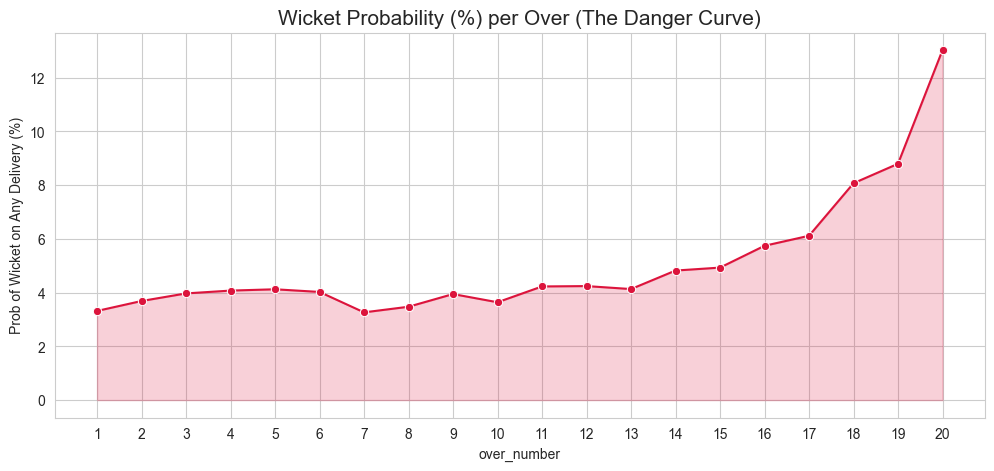

In [4]:
# Wicket Probability per Over
overs_total = ball_df.groupby('over_number').size()
overs_wickets = ball_df[ball_df['is_wicket'] == 1].groupby('over_number').size()
wicket_percent = (overs_wickets / overs_total * 100).reset_index(name='prob')

plt.figure(figsize=(12, 5))
sns.lineplot(data=wicket_percent, x='over_number', y='prob', marker='o', color='crimson')
plt.fill_between(wicket_percent['over_number'], wicket_percent['prob'], alpha=0.2, color='crimson')
plt.title("Wicket Probability (%) per Over (The Danger Curve)", fontsize=15)
plt.ylabel("Prob of Wicket on Any Delivery (%)")
plt.xticks(range(1, 21))
plt.savefig(os.path.join(FIGURE_PATH, "07_wicket_probability.png"))
plt.show()

### Insight
The final over (20) is statistically the most dangerous, with a **wicket probability exceeding 10% per ball**. This highlights the high-risk 'all-or-nothing' approach taken in the closing stages of the game.

## 3.3 Pressure Metrics: CRR vs RRR Dynamics

In a game of 120 balls, the chase is a battle of run rates. We calculate situational leverage across a second-inning chase.

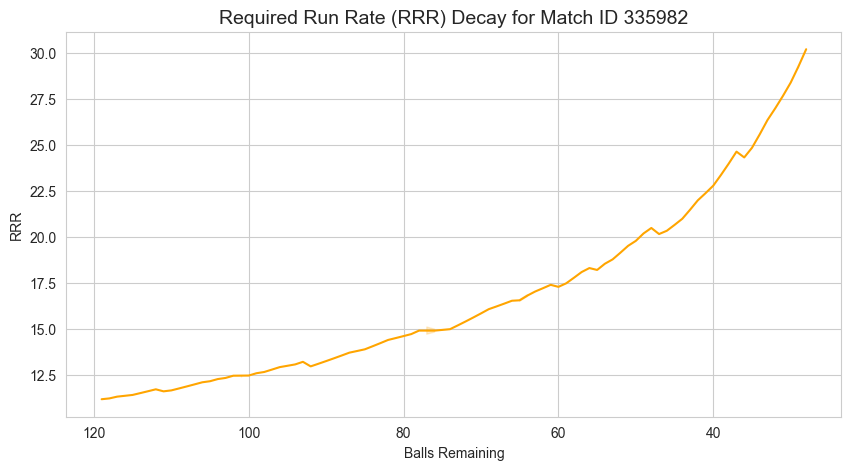

In [5]:
# Demonstrating Pressure for a single high-profile match (ID 335982)
match_id = 335982
sample_match = ball_df[ball_df['id'] == match_id].copy()

# This logic will be moved to src/ later, but for visualization:
innings = sample_match.groupby('inning')['total_runs'].sum()
target = innings[1] + 1

chase = sample_match[sample_match['inning'] == 2].copy()
chase['cumulative_runs'] = chase['total_runs'].cumsum()
chase['runs_left'] = target - chase['cumulative_runs']
chase['balls_left'] = 120 - (((chase['over']) * 6) + chase['ball'])
chase['rrr'] = (chase['runs_left'] / chase['balls_left']) * 6

plt.figure(figsize=(10, 5))
sns.lineplot(data=chase, x='balls_left', y='rrr', color='orange')
plt.gca().invert_xaxis()
plt.title(f"Required Run Rate (RRR) Decay for Match ID {match_id}", fontsize=14)
plt.xlabel("Balls Remaining")
plt.ylabel("RRR")
plt.savefig(os.path.join(FIGURE_PATH, "08_rrr_pressure_sample.png"))
plt.show()

## 3.4 Batsman Performance: Consistency vs Explosion

In [6]:
batsman_stats = ball_df.groupby('batsman').agg({
    'batsman_runs': 'sum',
    'ball': 'count'
}).reset_index()
batsman_stats['strike_rate'] = (batsman_stats['batsman_runs'] / batsman_stats['ball']) * 100
top_scorers = batsman_stats[batsman_stats['batsman_runs'] > 2000]  # Minimum 2000 runs

fig = px.scatter(top_scorers, x='batsman_runs', y='strike_rate', text='batsman',
                 title="Value vs Aggression: Top IPL Run Scorers",
                 labels={'batsman_runs': 'Total Runs', 'strike_rate': 'Strike Rate (%)'},
                 color='strike_rate', size='batsman_runs', color_continuous_scale='Magma')
fig.update_traces(textposition='top center')
fig.write_image(os.path.join(FIGURE_PATH, "09_batsman_aggression.png"))
fig.show()

### Insight
The scatter plot separates "Stabilizers" (High runs, moderate strike rate like Virat Kohli) from "Explosive Finishers" (Moderate runs, outlier strike rates like AB de Villiers). For win prediction, having explosive finishers in the final 5 overs is a stronger signal than cumulative anchor runs.